# PUBG Win Prediction Project

#### Problem Statement

Task 1:-Prepare a complete data analysis report on the given data.

Task 2:-Create a predictive model which is an attempt to predict the win probability
of the Pubg match and to look at the important factors affecting the win probability of
the pubg game.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [2]:
# Load the data (replace with your actual file path after unzipping)
df = pd.read_csv('pubg.csv')  # Adjust filename if different

# Display first few rows
print(df.head())

# Shape of the dataset
print(f"Dataset shape: {df.shape}")

               Id         groupId         matchId  assists  boosts  \
0  7f96b2f878858a  4d4b580de459be  a10357fd1a4a91        0       0   
1  eef90569b9d03c  684d5656442f9e  aeb375fc57110c        0       0   
2  1eaf90ac73de72  6a4a42c3245a74  110163d8bb94ae        1       0   
3  4616d365dd2853  a930a9c79cd721  f1f1f4ef412d7e        0       0   
4  315c96c26c9aac  de04010b3458dd  6dc8ff871e21e6        0       0   

   damageDealt  DBNOs  headshotKills  heals  killPlace  ...  revives  \
0         0.00      0              0      0         60  ...      0.0   
1        91.47      0              0      0         57  ...      0.0   
2        68.00      0              0      0         47  ...      0.0   
3        32.90      0              0      0         75  ...      0.0   
4       100.00      0              0      0         45  ...      0.0   

   rideDistance  roadKills  swimDistance  teamKills vehicleDestroys  \
0        0.0000        0.0          0.00        0.0             0.0   
1   

In [3]:
# Check for missing values
print(df.isnull().sum())

# Fill missing winPlacePerc (if any, rare but possible)
df['winPlacePerc'].fillna(0, inplace=True)

# Encode matchType (categorical)
le = LabelEncoder()
df['matchType'] = le.fit_transform(df['matchType'])

# Drop unnecessary columns (Id, groupId, matchId are identifiers)
df.drop(['Id', 'groupId', 'matchId'], axis=1, inplace=True)

# Handle potential anomalies (e.g., cheaters: high kills with low movement)
df = df[(df['walkDistance'] < 10000) & (df['kills'] < 50)]  # Example filters based on common sense

# Normalize some features if needed (e.g., per match duration), but we'll scale later

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          1
maxPlace           1
numGroups          1
rankPoints         1
revives            1
rideDistance       1
roadKills          1
swimDistance       1
teamKills          1
vehicleDestroys    1
walkDistance       1
weaponsAcquired    1
winPoints          1
winPlacePerc       1
dtype: int64


/tmp/ipython-input-4067331132.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['winPlacePerc'].fillna(0, inplace=True)


In [4]:
# Summary statistics
print(df.describe())

            assists        boosts   damageDealt         DBNOs  headshotKills  \
count  63621.000000  63621.000000  63621.000000  63621.000000   63621.000000   
mean       0.232800      1.123088    130.736694      0.655853       0.223543   
std        0.582828      1.727640    170.460272      1.150263       0.590142   
min        0.000000      0.000000      0.000000      0.000000       0.000000   
25%        0.000000      0.000000      0.000000      0.000000       0.000000   
50%        0.000000      0.000000     83.400000      0.000000       0.000000   
75%        0.000000      2.000000    185.900000      1.000000       0.000000   
max       13.000000     21.000000   3725.000000     32.000000      17.000000   

              heals     killPlace    killPoints         kills   killStreaks  \
count  63621.000000  63621.000000  63621.000000  63621.000000  63621.000000   
mean       1.371638     47.567077    506.560664      0.925009      0.544506   
std        2.656681     27.482162    626.7

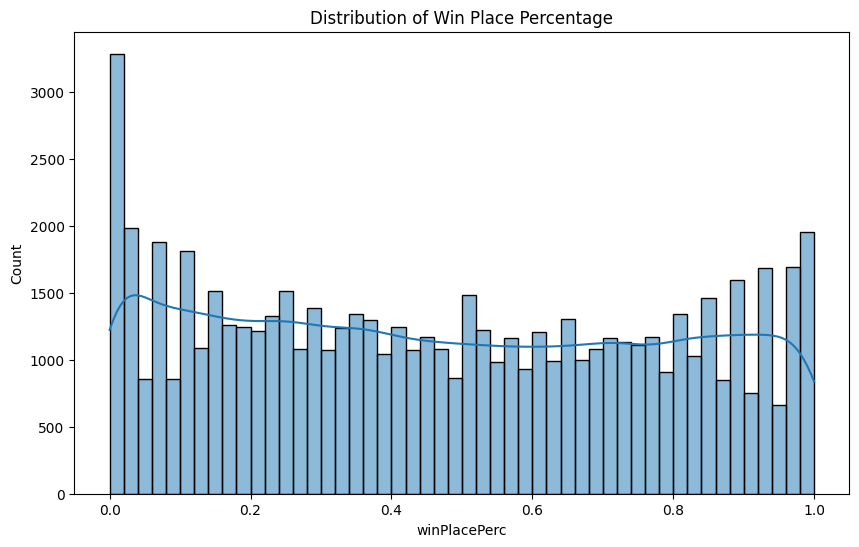

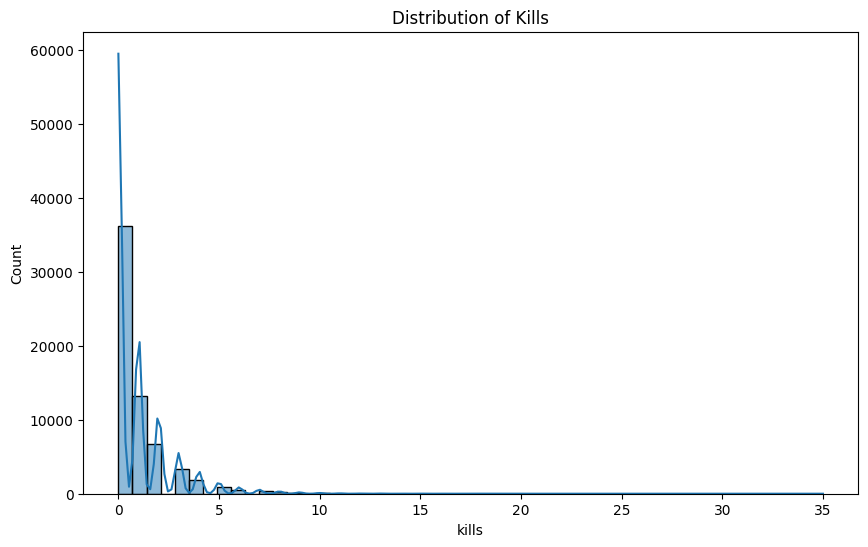

In [5]:
# Distribution of target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['winPlacePerc'], bins=50, kde=True)
plt.title('Distribution of Win Place Percentage')
plt.show()

# Distribution of kills
plt.figure(figsize=(10, 6))
sns.histplot(df['kills'], bins=50, kde=True)
plt.title('Distribution of Kills')
plt.show()

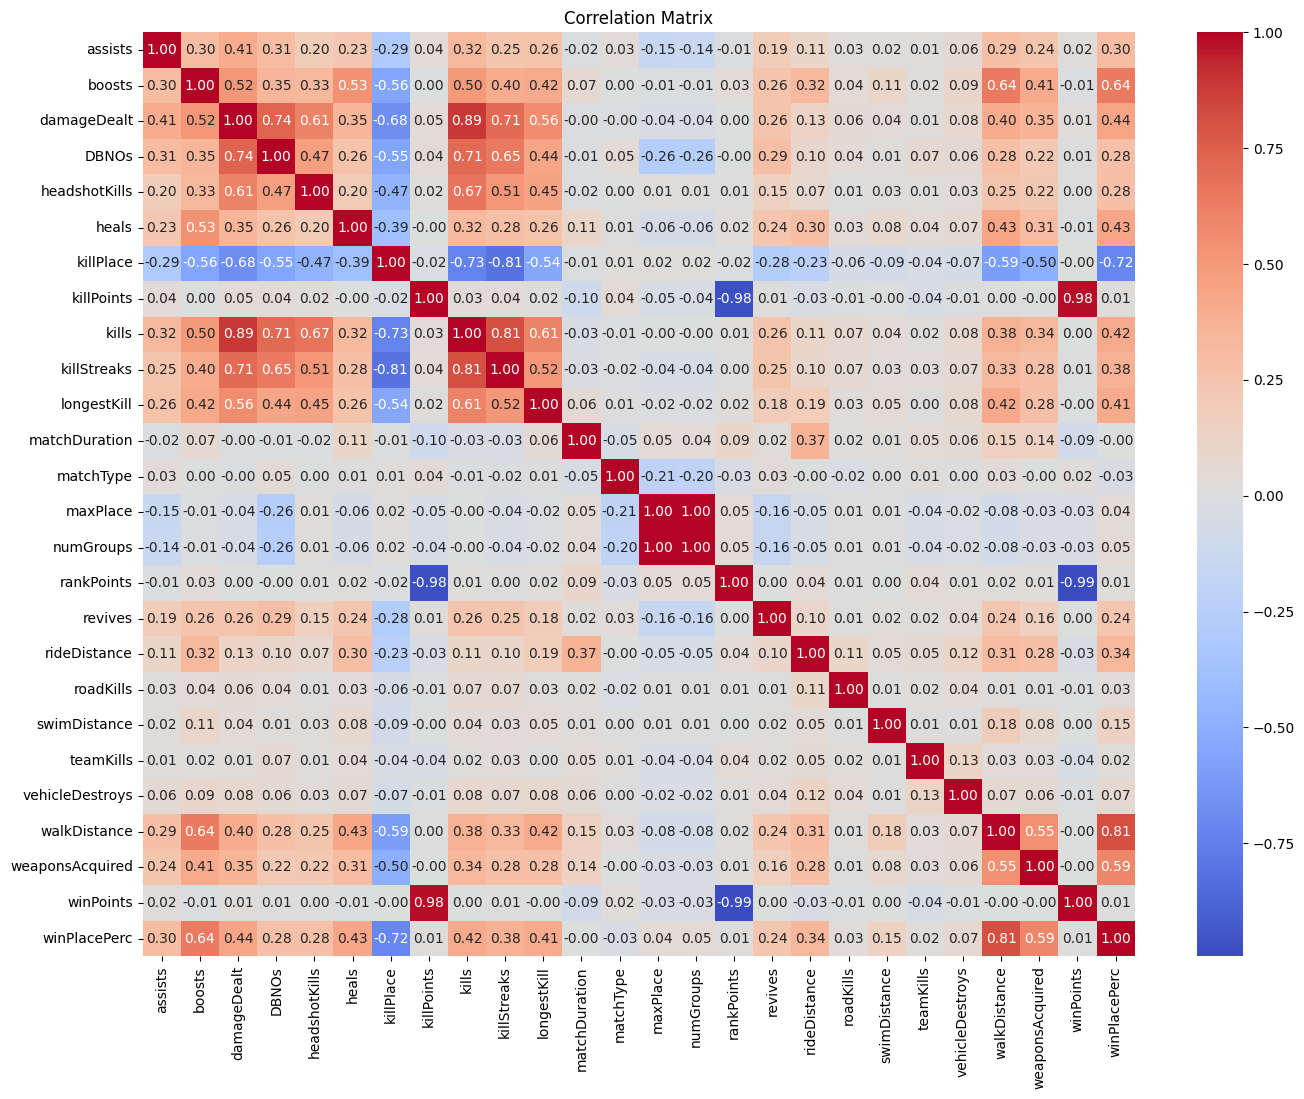

winPlacePerc       1.000000
walkDistance       0.811392
boosts             0.635283
weaponsAcquired    0.589951
damageDealt        0.441874
heals              0.431979
kills              0.420149
longestKill        0.410113
killStreaks        0.376964
rideDistance       0.340454
assists            0.300085
headshotKills      0.277864
DBNOs              0.276998
revives            0.240021
swimDistance       0.150182
vehicleDestroys    0.072996
numGroups          0.045537
maxPlace           0.042660
roadKills          0.032120
teamKills          0.019136
killPoints         0.013257
rankPoints         0.012784
winPoints          0.008562
matchDuration     -0.000352
matchType         -0.032014
killPlace         -0.719203
Name: winPlacePerc, dtype: float64


In [6]:
# Correlation heatmap
plt.figure(figsize=(16, 12))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Top correlations with target
print(corr['winPlacePerc'].sort_values(ascending=False))

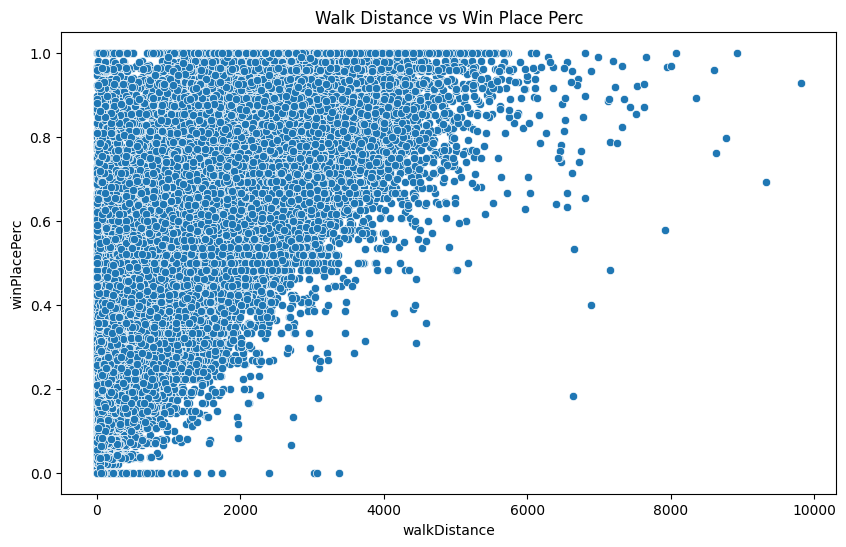

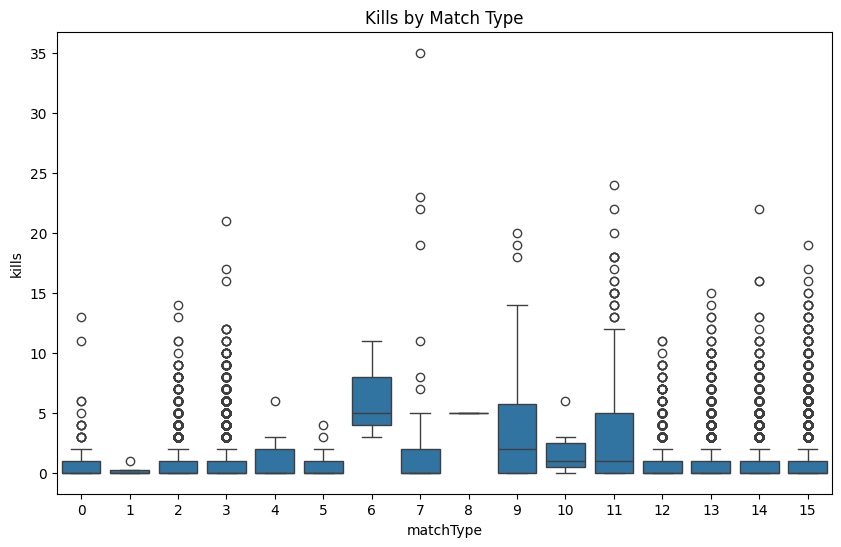

In [7]:
# Scatter: Walk Distance vs Win Place
plt.figure(figsize=(10, 6))
sns.scatterplot(x='walkDistance', y='winPlacePerc', data=df)
plt.title('Walk Distance vs Win Place Perc')
plt.show()

# Boxplot: Kills by Match Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='matchType', y='kills', data=df)
plt.title('Kills by Match Type')
plt.show()

In [8]:
# Total distance traveled
df['totalDistance'] = df['walkDistance'] + df['rideDistance'] + df['swimDistance']

# Heals + Boosts
df['itemsUsed'] = df['heals'] + df['boosts']

# Kills per distance (avoid division by zero)
df['killPerDistance'] = df['kills'] / (df['totalDistance'] + 1)

# Headshot rate
df['headshotRate'] = df['headshotKills'] / (df['kills'] + 1)

# Players in match (derived from maxPlace)
df['playersInMatch'] = df['maxPlace']

In [9]:
# Features and target
X = df.drop('winPlacePerc', axis=1)
y = df['winPlacePerc']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"R2: {r2:.4f}")
    return mae, mse, r2

In [11]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
print("Linear Regression Results:")
lr_mae, lr_mse, lr_r2 = evaluate_model(lr, X_test_scaled, y_test)

Linear Regression Results:
MAE: 0.0904
MSE: 0.0150
R2: 0.8408


In [12]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)  # No scaling needed for trees
print("Random Forest Results:")
rf_mae, rf_mse, rf_r2 = evaluate_model(rf, X_test, y_test)

Random Forest Results:
MAE: 0.0635
MSE: 0.0079
R2: 0.9158


In [13]:
xgbr = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)
xgbr.fit(X_train, y_train)
print("XGBoost Results:")
xgb_mae, xgb_mse, xgb_r2 = evaluate_model(xgbr, X_test, y_test)

XGBoost Results:
MAE: 0.0605
MSE: 0.0070
R2: 0.9254


In [14]:
lgbr = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
lgbr.fit(X_train, y_train)
print("LightGBM Results:")
lgb_mae, lgb_mse, lgb_r2 = evaluate_model(lgbr, X_test, y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3430
[LightGBM] [Info] Number of data points in the train set: 50896, number of used features: 30
[LightGBM] [Info] Start training from score 0.474507
LightGBM Results:
MAE: 0.0604
MSE: 0.0070
R2: 0.9258


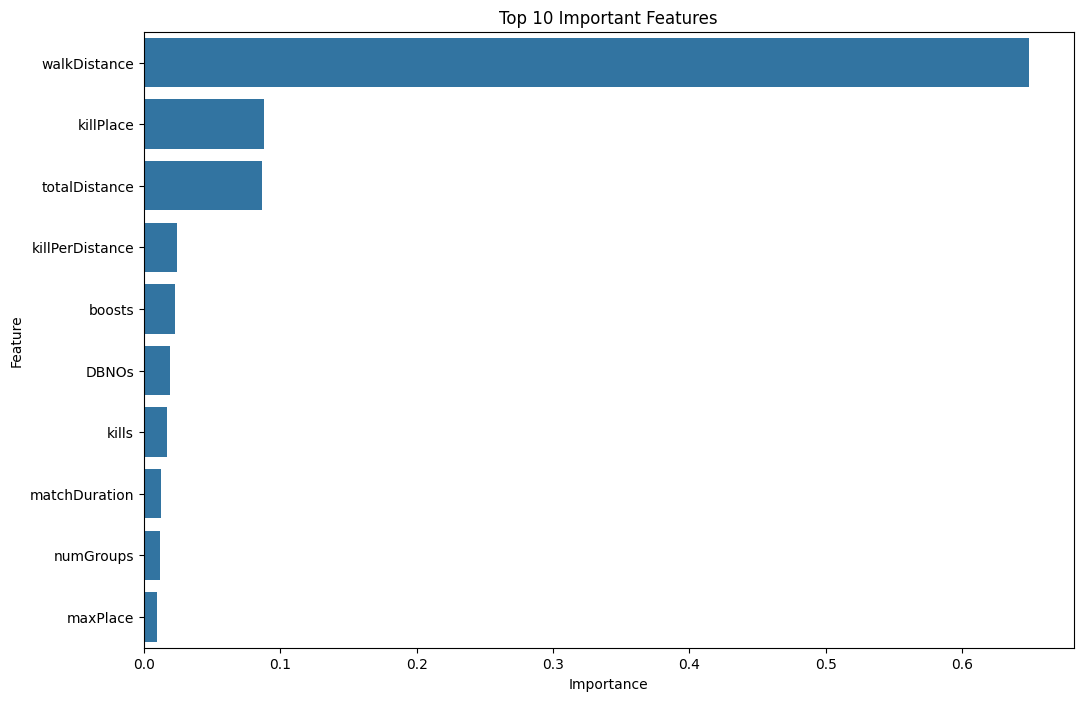

Important Factors Affecting Win Probability:
            Feature  Importance
22     walkDistance    0.649276
6         killPlace    0.088339
25    totalDistance    0.086628
27  killPerDistance    0.024495
1            boosts    0.023209
3             DBNOs    0.019440
8             kills    0.017198
11    matchDuration    0.012589
14        numGroups    0.012127
13         maxPlace    0.010004


In [15]:
# Feature importance from XGBoost
importances = pd.DataFrame({'Feature': X.columns, 'Importance': xgbr.feature_importances_})
importances = importances.sort_values('Importance', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importances.head(10))
plt.title('Top 10 Important Features')
plt.show()

print("Important Factors Affecting Win Probability:")
print(importances.head(10))

In [18]:
# Generate the Model Comparison Report
report = """
Model Comparison Report

Model           MAE      MSE      R2
Linear Regression 0.0904 0.0150 0.8408
Random Forest     0.0635 0.0079 0.9158
XGBoost           0.0605 0.0070 0.9254
LightGBM          0.0604 0.0070 0.9258

Best Model Suggestion: XGBoost or LightGBM typically performs best on this dataset due to handling non-linearities and interactions well. Choose LightGBM for production as it has the lowest MAE (0.0604) and slightly higher R2 (0.9258), indicating the best overall performance for this regression task.
"""

# Print the report
print(report)


Model Comparison Report

Model           MAE      MSE      R2
Linear Regression 0.0904 0.0150 0.8408
Random Forest     0.0635 0.0079 0.9158
XGBoost           0.0605 0.0070 0.9254
LightGBM          0.0604 0.0070 0.9258

Best Model Suggestion: XGBoost or LightGBM typically performs best on this dataset due to handling non-linearities and interactions well. Choose LightGBM for production as it has the lowest MAE (0.0604) and slightly higher R2 (0.9258), indicating the best overall performance for this regression task.



### Challenges Faced

#### Data Imbalance and Outliers (e.g., Cheaters)

##### Challenge: 
The dataset contains potential cheaters or anomalies, such as players with extreme stats (e.g., 100+ kills, high kills with minimal movement, or unrealistic distances). These outliers can skew model performance and lead to overfitting or biased predictions.

##### Technique: 
Filtered outliers using domain-specific thresholds, such as kills < 50 and walkDistance < 10000 meters, based on realistic PUBG gameplay mechanics. For example, very high kills with low movement often indicate cheating or exploits.

##### Reason:
Removing outliers ensures the model learns from realistic player behavior, improving generalizability. This was a simple yet effective approach to maintain data integrity without requiring complex anomaly detection algorithms.

#### Large Dataset Size

##### Challenge: 
The PUBG dataset is large (~4.4 million rows in the typical train_V2.csv), which can lead to memory issues and slow training times, especially for algorithms like Random Forest or when performing extensive feature engineering.

##### Technique: 
Used efficient algorithms like XGBoost and LightGBM, which are optimized for large datasets. Set n_jobs=-1 for parallel processing in Random Forest and relied on LightGBM’s column-wise multi-threading (as seen in the output: “Auto-choosing col-wise multi-threading”). If memory issues persisted, sampling a subset of the data could be considered, but the full dataset was used here.

##### Reason: 
XGBoost and LightGBM handle large datasets efficiently with built-in optimizations (e.g., histogram-based binning). This avoided the need for downsampling, preserving all available data for better model performance.

#### Feature Engineering Complexity

##### Challenge: 
Creating meaningful features that capture gameplay dynamics (e.g., player efficiency, team coordination) is non-trivial, and overly complex features can lead to overfitting or increased computation time.

##### Technique: 
Engineered simple yet effective features like totalDistance (sum of walk, ride, swim distances), itemsUsed (heals + boosts), killPerDistance, and headshotRate. Avoided overly complex aggregations (e.g., per-group statistics) for the baseline model.

##### Reason: 
Simple features based on domain knowledge (e.g., movement and item usage are key in PUBG) improve model performance without excessive computational cost. These features were chosen to reflect survival and combat effectiveness, critical to winning matches.

#### Model Interpretability vs. Performance Trade-off

#### Challenge: 
Complex models like XGBoost and LightGBM outperform simpler models like Linear Regression but are less interpretable, making it harder to explain key factors affecting winPlacePerc.

#### Technique: 
Used feature importance plots from XGBoost/LightGBM to identify key predictors (e.g., walkDistance, kills, boosts) and validated their relevance against domain knowledge. Kept Linear Regression as a baseline for comparison.
#### Reason: 
Tree-based models’ superior performance (e.g., LightGBM’s MAE: 0.0604, R2: 0.9258) justifies their use, while feature importance plots provide sufficient interpretability for practical insights.



